# Original attempt

In [ ]:
# May have to install ipympl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import ipympl
import sklearn as sk

# Allow interactive plots
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
# Generate random data

def random_circular_data(r: float, sd: float, n: int):
  theta = np.random.rand(n) * 2 * np.pi

  x = r * np.cos(theta) + np.random.normal(loc=0, scale=sd, size=n)
  y = r * np.sin(theta) + np.random.normal(loc=0, scale=sd, size=n)

  return np.asarray([x, y])

def normalize(data):
  std = np.std(data, axis=1)[:, np.newaxis]
  mean = np.mean(data, axis=1)[:, np.newaxis]
  print("std", std.shape)
  print("mean", mean.shape)
  return (data - mean) / std

n = 100
r1 = 0.2
r2 = 0.7
sd1 = 0.03
sd2 = 0.03

data = np.concatenate(
    (
        random_circular_data(r1, sd1, n),
        random_circular_data(r2, sd2, n)
    ),
    axis=1
)

norm_data = normalize(data)

data1 = norm_data[:,:100]
data2 = norm_data[:,100:]

print(data.shape)

print(data1.shape)

sk_norm_data = sk.preprocessing.normalize(data)

print(np.std(sk_norm_data))

std (2, 1)
mean (2, 1)
(2, 200)
(2, 100)
0.07070952261471289


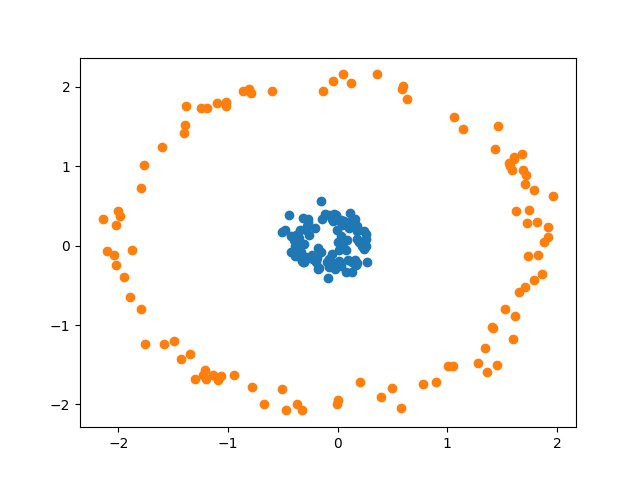

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(data1[0], data1[1])
ax.scatter(data2[0], data2[1])
plt.show()

std (3, 1)
mean (3, 1)


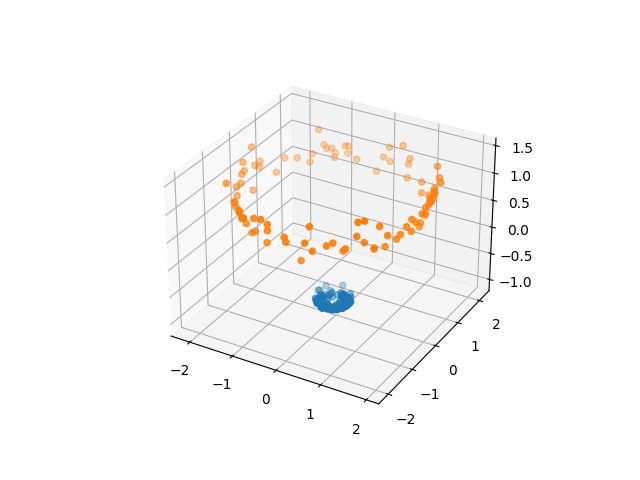

In [ ]:
data1 = random_circular_data(r1, sd1, 100)
data2 = random_circular_data(r2, sd2, 100)

data_with_radius2 = np.asarray([data[0], data[1], np.sum(np.power(data, 2), axis=0)])
norm_data_with_radius2 = normalize(data_with_radius2)

data1_with_radius2 = norm_data_with_radius2[:,:100]
data2_with_radius2 = norm_data_with_radius2[:,100:]


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(data1_with_radius2[0], data1_with_radius2[1], data1_with_radius2[2])
ax.scatter(data2_with_radius2[0], data2_with_radius2[1], data2_with_radius2[2])
plt.show()

In [ ]:
tot_data = np.concatenate((data1, data2), axis=1)
tot_data_with_radius2 = np.concatenate((data1_with_radius2, data2_with_radius2), axis=1)

print(tot_data.shape)
print(tot_data_with_radius2.shape)

pca1 = PCA(n_components=1)
pca1.fit(tot_data.T)
print("without radius^2", pca1.explained_variance_ratio_)
print(pca1.components_)

pca2 = PCA(n_components=1)
pca2.fit(tot_data_with_radius2.T)
print("with radius^2", pca2.explained_variance_ratio_)
print(pca2.components_)
print(pca2.n_features_in_)

(2, 200)
(3, 200)
without radius^2 [0.53781138]
[[ 0.65572688 -0.75499818]]
with radius^2 [0.36217299]
[[ 0.64476177 -0.17283814  0.74458662]]
3


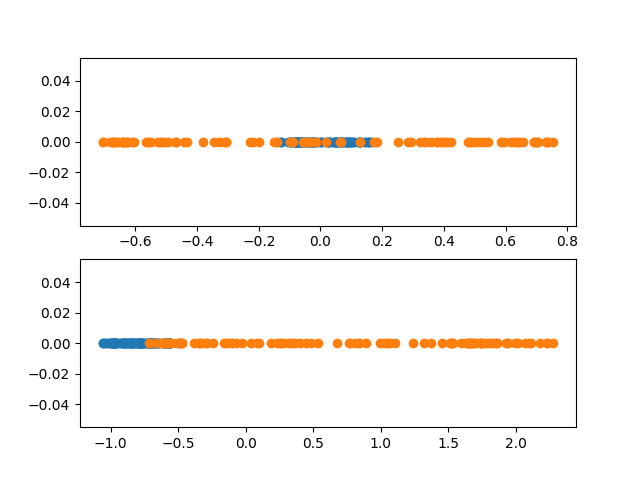

In [ ]:
pca_data1 = pca1.transform(data1.T).T
pca_data2 = pca1.transform(data2.T).T

pca_data1_with_radius2 = pca2.transform(data1_with_radius2.T).T
pca_data2_with_radius2 = pca2.transform(data2_with_radius2.T).T

fig, (ax1, ax2) = plt.subplots(2)

ax1.scatter(pca_data1, y=np.zeros(pca_data1.shape))
ax1.scatter(pca_data2, y=np.zeros(pca_data1.shape))
ax2.scatter(pca_data1_with_radius2, y=np.zeros(pca_data1.shape))
ax2.scatter(pca_data2_with_radius2, y=np.zeros(pca_data1.shape))
plt.show()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

# Introduction to Kernel PCY

In [ ]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.spatial.distance import cdist

X, y = make_circles(n_samples=1000, factor=0.0002, noise=0.1, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

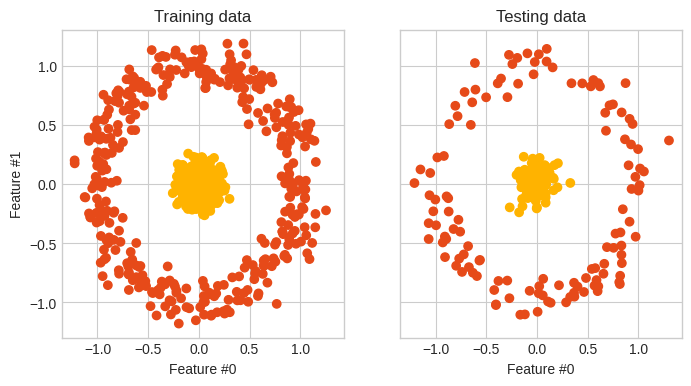

In [ ]:
import matplotlib.pyplot as plt

_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

colors = ['#FFB300' if e==1 else '#E64A19' for e in y_train]
train_ax.scatter(X_train[:, 0], X_train[:, 1], c=colors)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

colors = ['#FFB300' if e==1 else '#E64A19' for e in y_test]
test_ax.scatter(X_test[:, 0], X_test[:, 1], c=colors)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

In [ ]:
# X = nxm data matrix where n is number of samples, m is number of features
# kernel  = RBF in this case
# d = number of principal components to be chosen

import warnings
import seaborn as sns
def rbf(x, y, gamma):
  '''
  Define radial basis function kernel
  k(x,y) = exp (- gamma * ||x-y||**2)
  Hyperparameter: gamma
  '''
  return np.exp(- gamma * np.linalg.norm(x-y)**2)

def kernel_matrix(X, gamma):
  """
  Compute kernel matrix
  """
  n, m = X.shape
  K = []

  for fil in range(m):
    k_aux = []

    for col in range(m):
      k_aux.append(rbf(X[:,fil], X[:, col], gamma))

    K.append(k_aux)
  K = np.array(K)

  # Centre K
  ones = np.ones((K.shape[0], K.shape[1]))/m

  K = K - ones@K - K@ones + ones@K@ones
  return K

def project(K, d):

  # Decompose K and normalise and order tuples of (singular_value, eigenvector) by size
  eigval, eigvec = np.linalg.eig(K)

  if not np.all(eigval) > 0:
    warnings.warn("K is not positive semidefinite")

  tuples_eig = [(np.sqrt(eigval[i]), eigvec[:,i]/np.sqrt(eigval[i])) for i in range(len(eigval))]
  tuples_eig.sort(key=lambda x: x[0], reverse = True)

  # Compute scores

  tuples_eig_dim = tuples_eig[:d]

  sigma = np.diag([i[0] for i in tuples_eig_dim]) # Diagonal matrix of singular values
  print(sigma)
  sigma = np.real_if_close(sigma, tol=1)

  v = np.array([list(j[1]) for j in tuples_eig_dim]).T # Matrix of eigenvectors
  v = np.real_if_close(v, tol=1)

  scores = sigma @ v.T

  return tuples_eig, sigma, v, scores

def plot_singular_values(tuples_eig, grid=True):
  eig_plot = [np.real_if_close(e, tol=1) for (e, _) in tuples_eig if e > 0.01]
  plt.style.use('seaborn-whitegrid')
  fig = plt.figure(figsize=(15,7.5))
  plt.plot(list(range(1, len(eig_plot) + 1)), eig_plot)
  plt.grid(grid)
  plt.title('Singular values of the matrix $K$ different from 0')
  plt.ylabel('$\sigma^2$')
  plt.show()


def plot_scores_2d(scores, d, colors, grid = True, dim_1 = 1, dim_2 = 2):

  if d < 2:
    warnings.warn("Not sufficient number of principal components")
    return

  plt.style.use('seaborn-whitegrid')
  fig = plt.figure(figsize=(15,10))
  plt.axhline(c = 'black', alpha = 0.2)
  plt.axvline(c = 'black', alpha = 0.2)
  plt.scatter(scores[dim_1 - 1,:], scores[dim_2 - 1,:], c = colors)
  plt.grid(grid)
  plt.title('KPCA Space')
  plt.xlabel('${}^a$ principal component in space $\phi(X)$'.format(dim_1))
  plt.ylabel('${}^a$ principal component in space $\phi(X)$'.format(dim_2))
  plt.show()

def plot_scores_3d(scores, d, colors, grid = True, dim_1 = 1, dim_2 = 2, dim_3 = 3):
        if d < 3:
            warnings.warn("Not sufficient principal components. Required 3")
            return

        plt.style.use('seaborn-whitegrid')
        fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(scores[dim_1 - 1,:], scores[dim_2 - 1,:], scores[dim_3 - 1,:], c = colors)
        plt.grid(grid)
        ax.axis('on')
        plt.title('KPCA Space')
        ax.set_xlabel('${}^a$ componente principal en el espacio $\phi(X)$'.format(dim_1))
        ax.set_ylabel('${}^a$ componente principal en el espacio $\phi(X)$'.format(dim_2))
        ax.set_zlabel('${}^a$ componente principal en el espacio $\phi(X)$'.format(dim_3))
        plt.show()

def plot_density(scores, labels, dim=1, grid = False):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(15,5))
    for ele in np.unique(labels):
        sns.distplot(scores[dim - 1,:][np.where(labels == ele)], hist = False,
                      kde = True, kde_kws = {'linewidth': 3}, label = ele)
    plt.grid(grid)
    plt.legend()
    plt.title('Distribution in ${}^a$ principal component'.format(dim))
    plt.show()



[[10.72176964+0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  7.53633682+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  7.17960114+0.j]]


<ipython-input-57-6d02dfba6027>:65: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


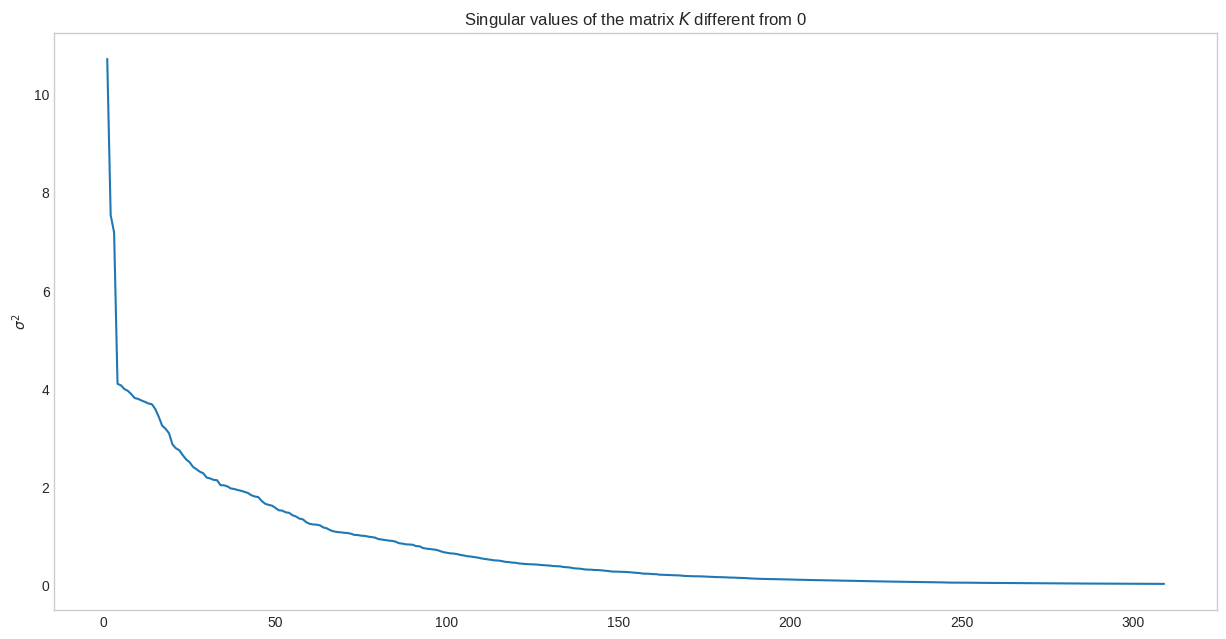

In [ ]:
gamma = 25
d = 3

K = kernel_matrix(X_train.T, gamma)
K.shape
np.diag([1,1])

tuples_eig, sigma, v, scores = project(K, d)

plot_singular_values(tuples_eig, grid=False)


<ipython-input-61-5babee401ccc>:92: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
<ipython-input-61-5babee401ccc>:95: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scores[dim - 1,:][np.where(labels == ele)], hist = False,
<ipython-input-61-5babee401ccc>:95: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code

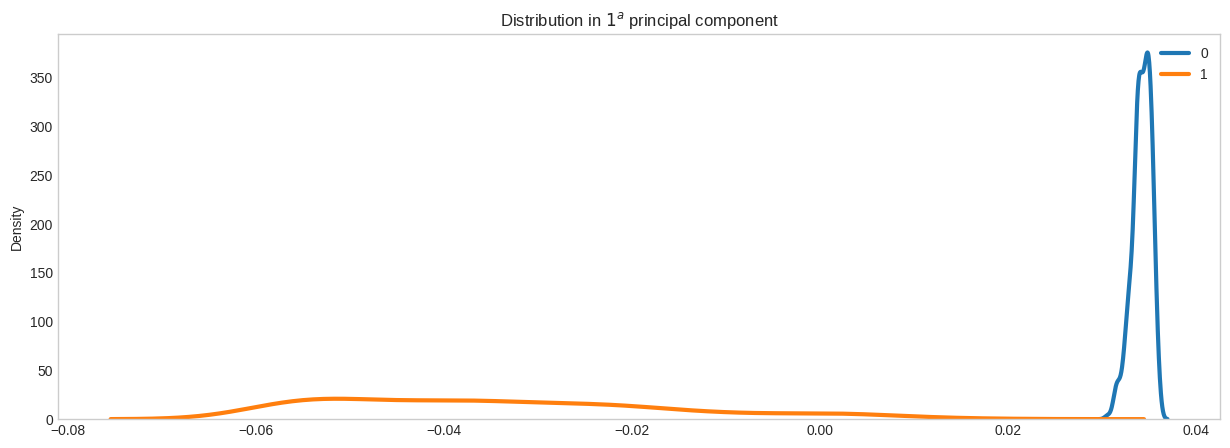

<ipython-input-61-5babee401ccc>:80: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


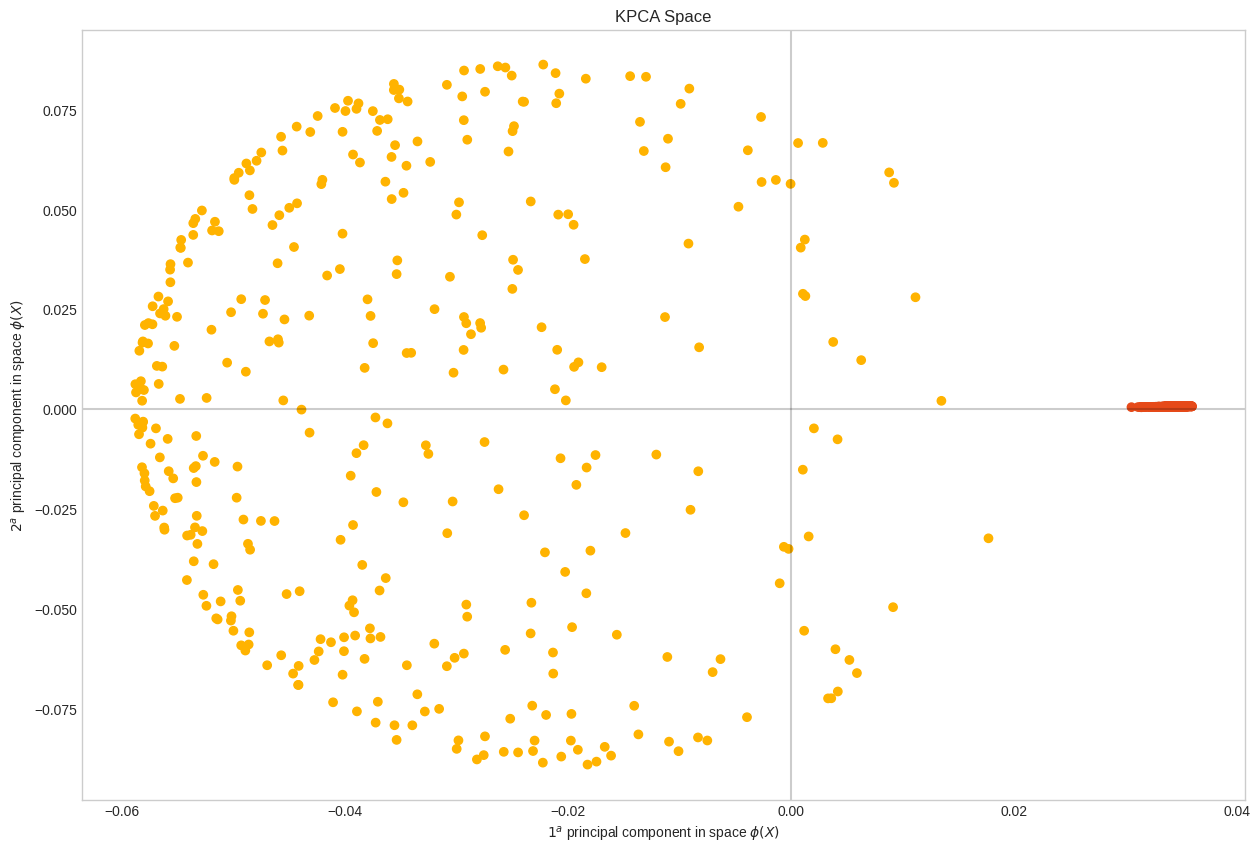

In [ ]:
  colors = ['#FFB300' if e==1 else '#E64A19' for e in y_train]

plot_density(scores, labels = y_train)
plot_scores_2d(scores, d, colors, grid = False)

<ipython-input-65-7f468c67e586>:96: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


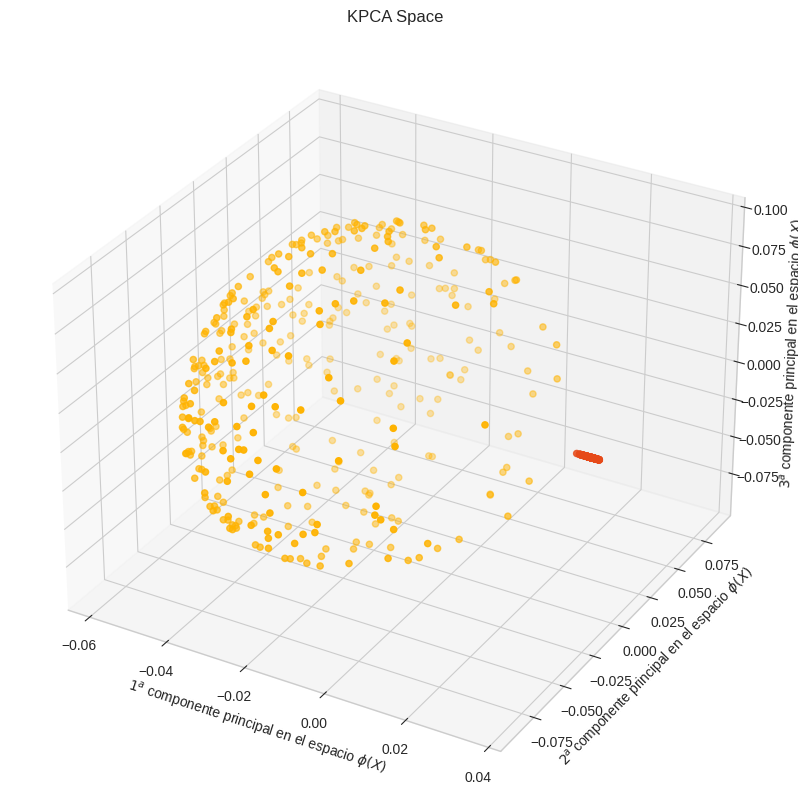

In [ ]:
plot_scores_3d(scores, d, colors)

# Kernel PCA using SVD

## Sources:
- https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca
- https://github.com/JAVI897/Kernel-PCA/tree/master
- https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html
- https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html

In [ ]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_kernels
from scipy.linalg import eigh, svd
from sklearn.preprocessing import KernelCenterer
from sklearn.datasets import make_circles
import scipy
import seaborn as sns
import sklearn
from sklearn.decomposition import KernelPCA


## Create circle dataset

Here we create data generated from circles of different radii + noise. Clearly, the data is not linearly separable.

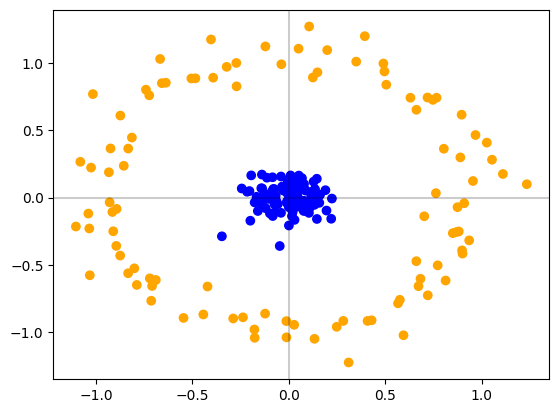

In [ ]:
N = 200

X, Y = make_circles(n_samples=N, noise = 0.1, factor= 0.0002)
colors = ['blue' if e==1 else 'orange' for e in Y]

plt.axhline(c = 'black', alpha = 0.2)
plt.axvline(c = 'black', alpha = 0.2)
plt.scatter(X[:,0], X[:,1], c = colors)
plt.grid(False)
plt.show()


## Define kernel functions
Here we define a linear kernel and a radial basis function (RBF) kernel but there can be others.

Kernels can also be created using SciKit Learn's pairwise_kernels function:

    K = sklearn.metrics.pairwise.pairwise_kernels(X, metric="rbf", gamma=25)
    K = sklearn.metrics.pairwise.pairwise_kernels(X, metric="laplacian")

In [ ]:
def linear_kernel(x, y, c=0):

    return x.T@y + c

def rbf_kernel(x, y, gamma=25):

    return np.exp(-gamma * (np.linalg.norm(x-y)**2))

## Select kernel to use

In [ ]:
kernel_func = rbf_kernel

## Construct kernel

In [ ]:
num_samples, num_features = X.shape

K = np.zeros((num_samples, num_samples))

for i in range(K.shape[0]):
    for j in range(K.shape[1]):
        K[i, j] = kernel_func(x=X[i,:], y=X[j,:])

# Centering K
ones = np.ones(K.shape) / num_samples
K = K - ones@K - K@ones + ones@K@ones

In [ ]:
K.shape

(200, 200)

## Run Singular Value Decomposition (SVD)
$X = U Σ V^T$

$\Sigma$: singular values of X

$U$: left singular vectors of X

$V$: right singular vectors of X

In [ ]:
C = K.T @ K / (num_samples - 1) # Covariance matrix

U, s, V = scipy.linalg.svd(a=C, full_matrices=True)

In [ ]:
singular_values = s # Sigma

eigenvalues = s**2
eigenvectors = V # eigenvectors stored as rows

$T = U \Sigma$: scores

$P = V$: principal components

In [ ]:
principal_components = V

scores = U * s
scores = scores.T

## Plot the score distribution of PC1

<Figure size 640x480 with 0 Axes>

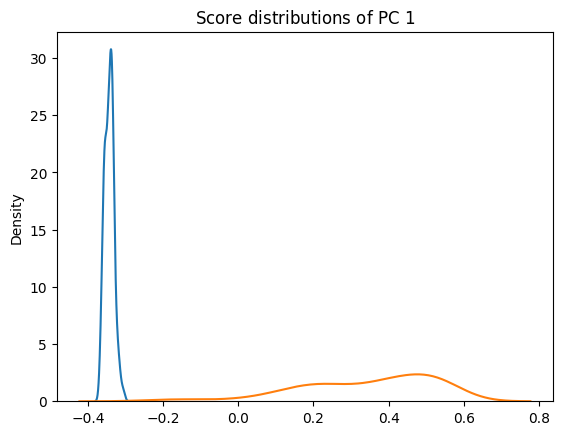

In [ ]:
labels = Y
component = 1

fig = plt.figure()
fig, ax = plt.subplots()

scores_0 = scores[component - 1,:][np.where(labels == 0)]
scores_1 = scores[component - 1,:][np.where(labels == 1)]

sns.kdeplot(scores_0)
sns.kdeplot(scores_1)

plt.grid(False)
plt.title('Score distributions of PC ${}$'.format(component))
plt.show()

## Score plot of PC1 and PC2 in 2D

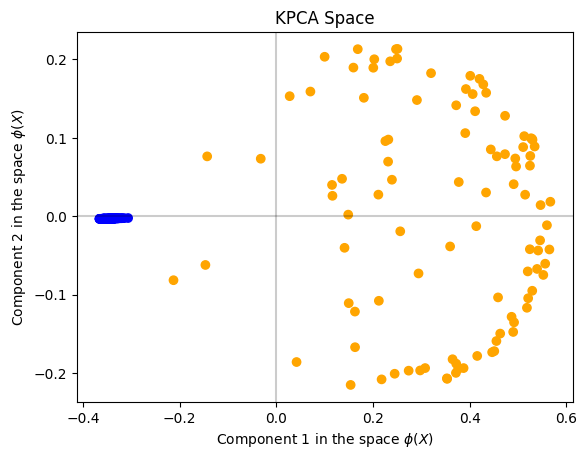

In [ ]:
component_1 = 1
component_2 = 2

fig = plt.figure()
plt.axhline(c = 'black', alpha = 0.2)
plt.axvline(c = 'black', alpha = 0.2)
plt.scatter(scores[component_1 - 1,:], scores[component_2 - 1,:], c = colors)
plt.grid(False)
plt.title('KPCA Space')
plt.xlabel('Component ${}$ in the space $\phi(X)$'.format(component_1))
plt.ylabel('Component ${}$ in the space $\phi(X)$'.format(component_2))
plt.show()

## Plot the score distribution of PC1, PC2, and PC3 in 3D

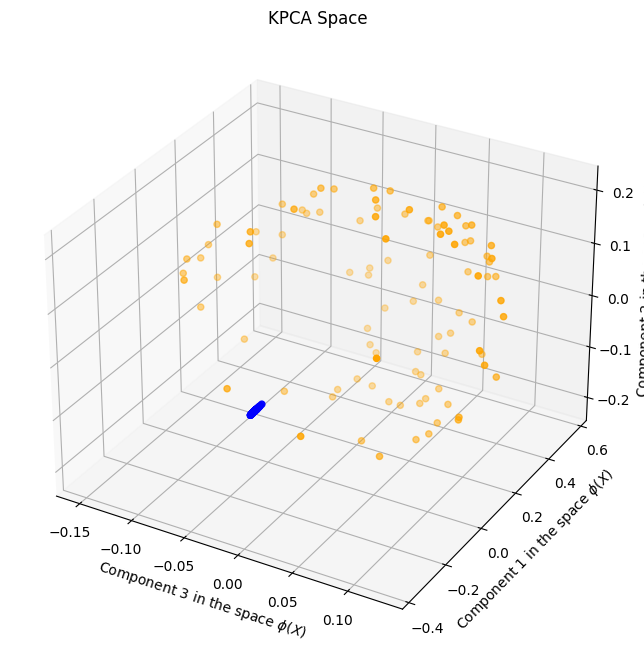

In [ ]:
component_1 = 3
component_2 = 1
component_3 = 2


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(scores[component_1 - 1,:],
           scores[component_2 - 1,:],
           scores[component_3 - 1,:],
           c = colors)

plt.grid(False)
ax.axis('on')
plt.title('KPCA Space')
ax.set_xlabel('Component ${}$ in the space $\phi(X)$'.format(component_1))
ax.set_ylabel('Component ${}$ in the space $\phi(X)$'.format(component_2))
ax.set_zlabel('Component ${}$ in the space $\phi(X)$'.format(component_3))
plt.show()

## Plot the singular values

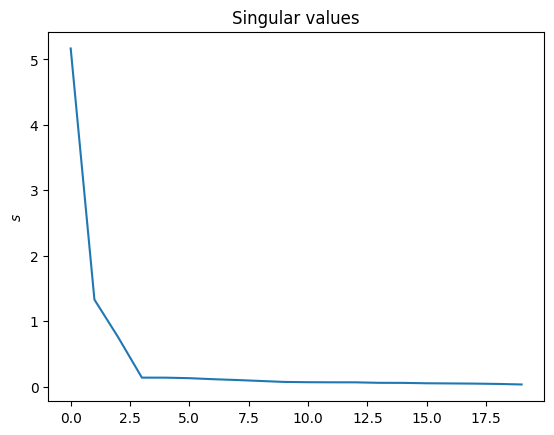

In [ ]:
x = singular_values
n = 20
fig = plt.figure()
plt.plot(list(range(0, n)), x[:n])
plt.grid(False)
plt.title('Singular values')
plt.ylabel('$s$')
plt.show()

## Perform Kernel PCA using SciKit-Learn

In [ ]:
kpca = KernelPCA(kernel="rbf", gamma=25)
X_kpca = kpca.fit_transform(X)


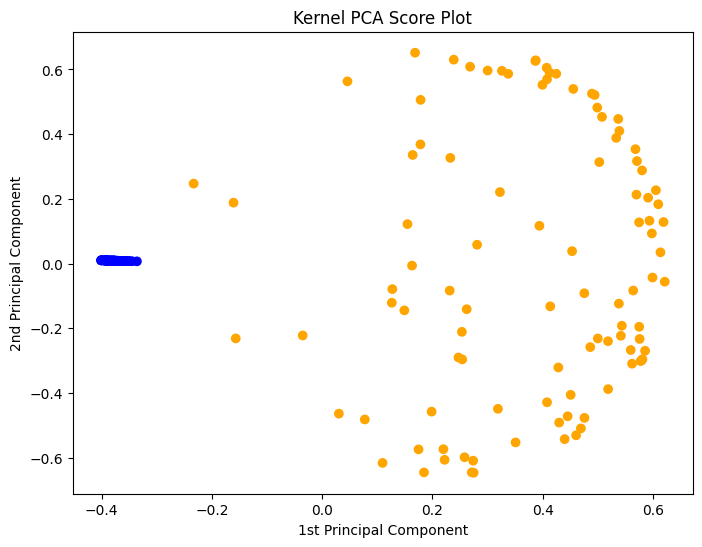

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=colors)
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title('Kernel PCA Score Plot')
plt.show()

In [ ]:
kpca.eigenvectors_

array([[-6.64850179e-02,  2.17047701e-03, -9.95908653e-04, ...,
        -1.11478678e-06, -6.97732957e-07,  3.56258104e-06],
       [ 4.48780698e-02, -7.35062322e-02, -1.66120729e-01, ...,
         3.41244345e-02,  7.65949652e-02, -1.44198244e-02],
       [-6.65716517e-02,  2.15907790e-03, -9.81348673e-04, ...,
        -1.05656088e-06, -7.90229887e-07,  3.26249155e-06],
       ...,
       [-6.69925388e-02,  2.20485849e-03, -1.01927613e-03, ...,
        -1.10768949e-06, -7.15812102e-07,  3.45679454e-06],
       [ 1.02028005e-01, -7.47852723e-02,  1.37933999e-02, ...,
         4.18785310e-02, -6.95466316e-02, -1.32437156e-01],
       [ 9.48560725e-02,  1.10844172e-01, -1.25602400e-02, ...,
         1.47259656e-01, -2.10168933e-02,  1.17183550e-01]])

In [ ]:
V.T

array([[-6.64850179e-02, -2.17047701e-03,  9.95908653e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.48780698e-02,  7.35062322e-02,  1.66120729e-01, ...,
         5.49912748e-01, -1.14855071e-01,  3.19237167e-01],
       [-6.65716517e-02, -2.15907790e-03,  9.81348673e-04, ...,
         1.58310165e-06, -2.81785952e-06, -2.43585489e-06],
       ...,
       [-6.69925388e-02, -2.20485849e-03,  1.01927613e-03, ...,
         1.91383081e-06, -2.62346115e-07, -1.01596368e-06],
       [ 1.02028005e-01,  7.47852723e-02, -1.37933999e-02, ...,
         5.86196075e-02, -2.20192357e-01, -2.61897865e-01],
       [ 9.48560725e-02, -1.10844172e-01,  1.25602400e-02, ...,
         1.00922800e-01,  1.32438019e-01, -6.62860131e-02]])